# 2026/02/23 BME1462: Morphological Image Processing II 

By Aaron Zeng, Zion Park, and Caresse Nian

## Topics of Focus: Hit-or-Miss Transform and Hole Filling (Morphological Algorithm)

## Library and Image Set Up

In [2]:
# Import Essential Libraries
from skimage import io, morphology
from skimage.morphology import erosion
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_fill_holes
from skimage.io import imread, imshow 
import skimage.morphology as morph 

# 1. Hit-or-Miss Transform
## 1.1 What is a Hit-or-Miss Transform?
The hit-or-miss (HMT) transform is a *binary morphological operator* that detects **exact spatial configurations**. In other words, it finds locations where a specific foreground shape exists **AND** a specific background pattern exists around it.

This is different from dilation and erosion, which only look at foreground.
- Erosion: Is the foreground shape  present?
- Dilation: Could the foreground shape fit?
- HMT: Is the shape present **and** is the surrounding area empty?

## 1.2 Mathematical Definition
$$ A \circledast (B_1, B_2) = (A \ominus B_1)\cap (A^c \ominus B_2) $$

Where:
- $ A $ = binary image (foreground = 1)
- $ B_1 $ = foreground structuring element (SE)
- $ B_2 $ = background SE

Interpretation:
- First erosion $A \ominus B_1$ checks **what must be present**
- Second erosion $A^c \ominus B_2$ checks **what must be absent**
- Intersection $\cap$ enforces both simultaneously

Alternatively: 
$$ I \circledast B = \{\ z \mid (B)_z \subseteq I \}\ $$

Where $(B)_z$ is checked if it's a subset of Image $I$, and Image $I$ is both foreground *and* background pixels.

## 1.3 Defining Foreground and Background SE
Take a look at the following candidate patterns:

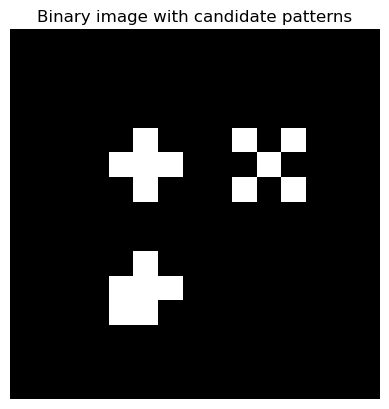

In [2]:
def show(img, title):
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    
img = np.zeros((15, 15), dtype=bool)

# perfect cross
img[4:7, 4:7] = [[0,1,0],
                 [1,1,1],
                 [0,1,0]]

# cross with extra pixel (should FAIL)
img[9:12, 4:7] = [[0,1,0],
                  [1,1,1],
                  [1,1,0]]

# rotated pattern (should FAIL)
img[4:7, 9:12] = [[1,0,1],
                  [0,1,0],
                  [1,0,1]]

show(img, "Binary image with candidate patterns")

Consider that the plus (+) pattern is the target. How can we demand *exact structure*?
- Foreground SE must encode prescence (center plus pattern)
- Background SE must encode absence (corners)

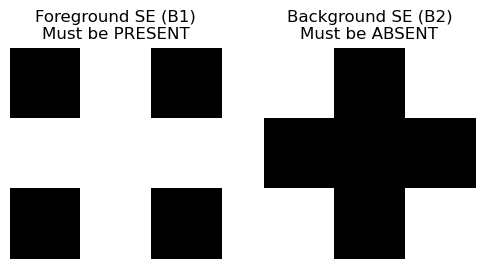

In [3]:
def show_side_by_side(img1, title1, img2, title2, cmap="gray"):
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap=cmap)
    plt.title(title1)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap=cmap)
    plt.title(title2)
    plt.axis("off")
    
B1 = np.array([[0,1,0],
               [1,1,1],
               [0,1,0]], dtype=bool)

B2 = np.array([[1,0,1],
               [0,0,0],
               [1,0,1]], dtype=bool)

show_side_by_side(
    B1, "Foreground SE (B1)\nMust be PRESENT",
    B2, "Background SE (B2)\nMust be ABSENT"
)

## 1.4 Why Erosion Alone is Not Enough (i.e. why must absence be explicitly specified?)
Let's try eroding using only the foreground SE:

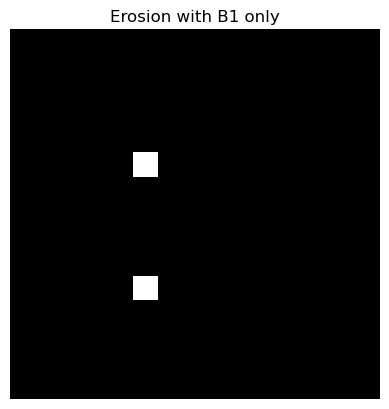

In [4]:
eroded_fg = #TODO: perform a foreground erosion
show(eroded_fg, "Erosion with B1 only")

**Result:**
- Multiple locations survive erosion $\rightarrow$ 'false' positives

**Interpretation:**

Erosion is able to answer "Is this foreground pattern present anywhere inside the neighborhood?", however is does *not* ask "Is anything extra present?".
- detects presence
- ignores absence

Now let's look at eroding the complement image using the background SE:

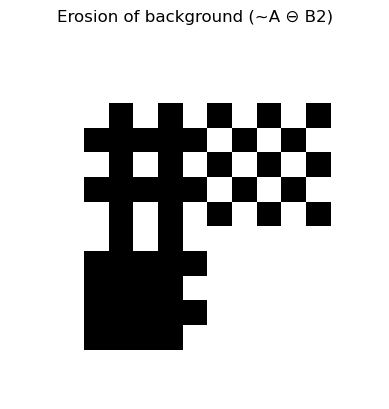

In [5]:
eroded_bg = #TODO: perform a background erosion 
show(eroded_bg, "Erosion of background (~A ⊖ B2)")

This enforces which pixels must be zero. 

### The Hit-or-Miss Transform Happens Here:
Intersect both conditions:

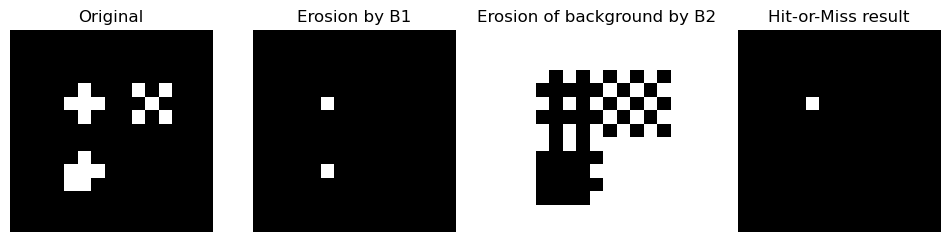

In [6]:
hit_or_miss_manual =  #TODO: complete the code to combine the two erosions performed above. HINT: use &

plt.figure(figsize=(12,3))

plt.subplot(1,4,1)
show(img, "Original")

plt.subplot(1,4,2)
show(eroded_fg, "Erosion by B1")

plt.subplot(1,4,3)
show(eroded_bg, "Erosion of background by B2")

plt.subplot(1,4,4)
show(hit_or_miss_manual, "Hit-or-Miss result")


By intersecting foreground SE and background SE erosion, the background SE is able to address the flaw of foreground SE erosion (i.e. does not ask "Is anything extra present?") by enforcing which pixels must be absent.

This results in only one detection, which is the center of the desired plus (+) pattern.

## 1.5 Why Does Hit-or-Miss Only Work on Binary Images?
HMT answers a boolean question at every pixel. Recall the definition:
$$ A \circledast (B_1, B_2) = (A \ominus B_1)\cap (A^c \ominus B_2) $$
A pixel is either in the set or not in the set.
### Issue with HMT on Greyscale Images
Greyscale erosion changes meaning:
$$(I \ominus B)(x) = \min_{b \in B} I(x + b)$$

This computes a minimum, not a subset test. It now asks if there are *low values nearby* rather than if the SE is *entirely present*.
HMT requires both existence of a pattern and non-existance of a pattern. In greyscale, existence becomes "large intensity" and non-existence as "small intensity" $\rightarrow$ the cutoff is now arbituary and context-dependent.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color, img_as_float, filters, measure, exposure, morphology
from scipy import ndimage

# 2. Choosing Structuring Elements

### Size and Shape
The size of the structuring element will depend on the size of the features that you would want to detect and the image and the shape will also depend on the shape of the features. Usually, you would want to match the shape of the structuring element to the shape of the feature you want to detect

There are many options in sckimage.morphology: disks, squares, rectangles and crosses.

C:\Users\zionp\AppData\Local\Temp\ipykernel_32984\3618912136.py:9: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  mask_closed = morphology.binary_closing(mask, morphology.disk(3))


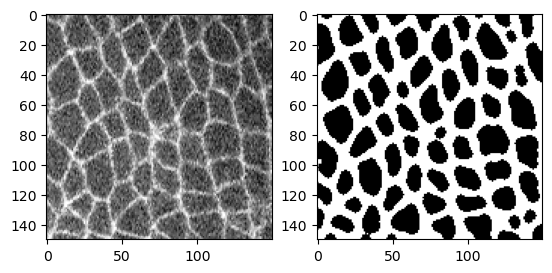

In [8]:
img = io.imread("cells.tif")
img_smooth = filters.gaussian(img, sigma = 2, preserve_range = True)
img_rescaled = exposure.rescale_intensity(
    img_smooth, out_range=np.uint8)

mask = img_rescaled >= filters.threshold_local(
    img_rescaled, 33, method='gaussian')

mask_closed = morphology.binary_closing(mask, morphology.disk(3))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, cmap='Greys_r')
axs[1].imshow(mask_closed, cmap='binary_r')
plt.show()

In [ ]:
disk = morphology.disk(0.125)
small_square = morphology.footprint_rectangle((3,3))
mid_square = morphology.footprint_rectangle((5,5))
large_square = morphology.footprint_rectangle((7,7))

img_small_square = #TODO: Try using HMT with a 3x3 structuring element
img_mid_square = #TODO: Try using HMT with a 5x5 structuring element

img_large_square = ndimage.binary_hit_or_miss(~mask_closed, large_square)
img_disk = ndimage.binary_hit_or_miss(~mask_closed, disk)

fig, axs = plt.subplots(1, 5)
fig.set_size_inches(20,20)

axs[0].set_title("Original")
axs[0].imshow(mask_closed, cmap='binary_r')

axs[1].set_title("Disk")
axs[1].imshow(img_disk, cmap='binary_r')

axs[2].set_title("3x3  Square")
axs[2].imshow(~img_small_square, cmap='binary_r')

axs[3].set_title("5x5 Square")
axs[3].imshow(~img_mid_square, cmap='binary_r')

axs[4].set_title("7x7  Square")
axs[4].imshow(~img_large_square, cmap='binary_r')
plt.show()

## Combining Structuring Elements

Structuring elements can only detect specific features within an image. To find more complex objects in the image, structuring elements can be combined together. 

For example, detecting a "T" with a single structuring element might be difficult but a "T" can broken down into two parts: a horizontal bar and a vertical bar. We can find each and then combine them together to get our "T".

In [10]:
sample_image = np.array([
    [0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1],
    [0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0]
])

sample_image_complement = 1 - sample_image

In [11]:
se_horizontal = np.array([
    [0,0,0],
    [1,1,1],
    [0,0,0]
])

se_vertical = np.array([
    [0,1,0],
    [0,1,0],
    [0,1,0]
])

se_background = np.array([
    [1,1,0],
    [1,1,0],
    [1,1,0]
])

In [12]:
# detecting the horizontal bar

foreground = ndimage.binary_erosion(sample_image, se_horizontal)
background_complement = ndimage.binary_erosion(sample_image_complement, se_background)
background = 1 - background_complement

horizontal_bar = foreground & background

In [13]:
# dectecting the vertical bar

# TODO: Try to isolate the vertical bar of the 'T' using ndimage.binary_erosion
foreground = #TODO 
background_complement = #TODO 
background = 1 - background_complement

vertical_bar = foreground & background

In [14]:
# combining the horizontal and vertical bars

obj = vertical_bar | horizontal_bar

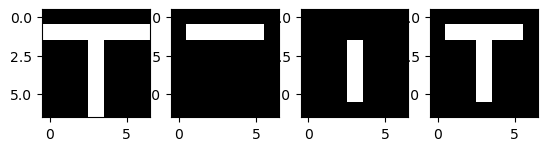

In [15]:
# comparison of the images

fig, axs = plt.subplots(1, 4)
axs[0].imshow(sample_image, cmap='binary_r')
axs[1].imshow(horizontal_bar, cmap='binary_r')
axs[2].imshow(vertical_bar, cmap='binary_r')
axs[3].imshow(obj, cmap='binary_r')
plt.show()

In [ ]:
# Importing essential libraries 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_fill_holes
import skimage
from skimage.io import imread, imshow 
import skimage.morphology as morph 

## Other Morphological Algorithms - Focus: Hole Filling ##

One of the most useful applications of morphological algorithms is the ability to extract image components that are useful for analysis further downstream. 

We will look at one common use-case: Hole Filling 

Recall that a 'hole' is simply a collection of background pixels surrounded by foreground pixels (object of interest)  
Refer to the binary image below to see several holes across multiple amorphous shapes reminiscent of cells:    

**Note the background (black) and the foreground (white)**  
![image](https://i.sstatic.net/j1ESv.png)  
*Photo taken from: https://stackoverflow.com/questions/22310489/filling-holes-in-objects-that-touch-the-border-of-an-image* 

### 3.1 Logic Behind the Algorithm ### 
Hole filling algorithm based on morphology can be expressed mathematically in the following manner: 

$$X_{k} = (X_{k-1} \oplus B) \cap I^c$$  $$k = 1, 2, 3, ...$$  

Say that there is a shape $A$ that has a hole in the image $I$

What hole-filling does:  
1. A new array $X$ of "0"'s is created with the same dimensions of $I$  
2. Each position of $X$ where there would be a hole in $I$, these pixel positions are set to "1" via dilation operation by structuring element $B$  
3. The conjunction/union operator with $I^c$ ensures that this iterative operation by $B$ becomes only valid for pixel positions within shape $A$ (the hole)  
4. Once it has converged, the shape $A$ and the now filled hole in $X$ are unified to form the filled shape  


Assuming a structuring element (3 x 3 cross) B, dilation iteratively performed, expanding the "On" pixels by one connectivity step each time while being constrained within the boundaries of the original shape thanks to the boundaries formed by the image's complement ($I^c$)

Scikit-image provides condensed methods to perform such operations. Below is a visual, step-by-step example of how hole filling algorithm works 


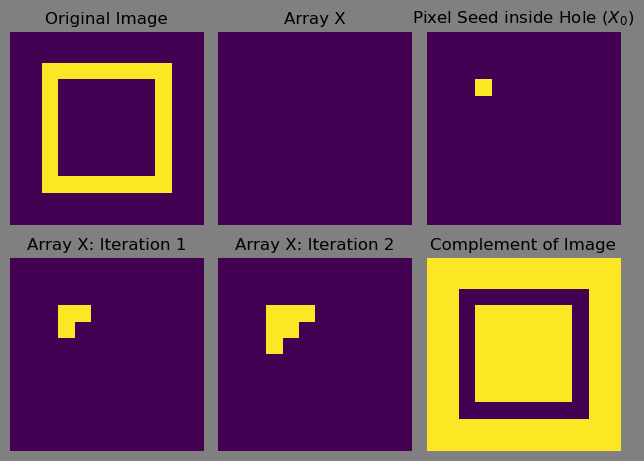

In [ ]:
image = np.zeros((12,12)); image[2:10, 2:10] = True; image[3:9, 3:9] = False # building a binary image with hole 
X_arraynot = np.zeros((12,12)) 
X_array = np.zeros((12,12)); X_array[3,3] = True # X_array with a seed at X_0
iteration1 = X_array.copy(); iteration1[3,4] = True; iteration1[4,3] = True
iteration2 = iteration1.copy(); iteration2[4,4] = True; iteration2[3,5] = True; iteration2[5,3] = True
I_c = 1 - image

fig, ax = plt.subplots(2,3) 
fig.set_facecolor('grey')
ax[0, 0].imshow(image); ax[0, 0].set_title('Original Image'); ax[0, 0].axis('off')
ax[0, 1].imshow(X_arraynot); ax[0, 1].set_title('Array X'); ax[0, 1].axis('off')
ax[0, 2].imshow(X_array); ax[0, 2].set_title('Pixel Seed inside Hole ($X_{0}$)'); ax[0, 2].axis('off')
ax[1, 0].imshow(iteration1); ax[1, 0].set_title("Array X: Iteration 1"); ax[1, 0].axis('off')
ax[1, 1].imshow(iteration2); ax[1, 1].set_title("Array X: Iteration 2"); ax[1, 1].axis('off')
ax[1, 2].imshow(I_c); ax[1,2].set_title("Complement of Image"); ax[1,2].axis('off')

plt.tight_layout()
plt.show()

### 3.2 Hole Filling Methods 
While the above attempts to explain the hole filling procedure, thankfully this is not necessary due to the use of existing methods from scikit image and by extension scipy library.  

For this we will use an example picture of a cell mask found on a Stack Overflow forum post:  
*https://stackoverflow.com/questions/22310489/filling-holes-in-objects-that-touch-the-border-of-an-image* 

As we have learned previously and based on the algorithm, hole filling utilizes dilation. But why not use solely binary dilation?  
Hole filling algorithm holds the advantage of constraining the dilation process to explicitly holes rather than the whole ('hole' - bad pun) image itself (referring back to intersection of $I^c$)  

Try playing around with the footprint variable, a square was used for convenience but feel free to call upon other available shapes, trying changing the size of the square and use `morph.binary_dilation` to see what happens to the original image. 

C:\Users\zionp\AppData\Local\Temp\ipykernel_34468\1799647529.py:2: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  footprint = morph.square(2) # TODO: test out different sizes of the square to fill out the holes of original image
C:\Users\zionp\AppData\Local\Temp\ipykernel_34468\1799647529.py:3: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  dilation = morph.binary_dilation(img, footprint= footprint) # NOTE: this line would be empty for exercise


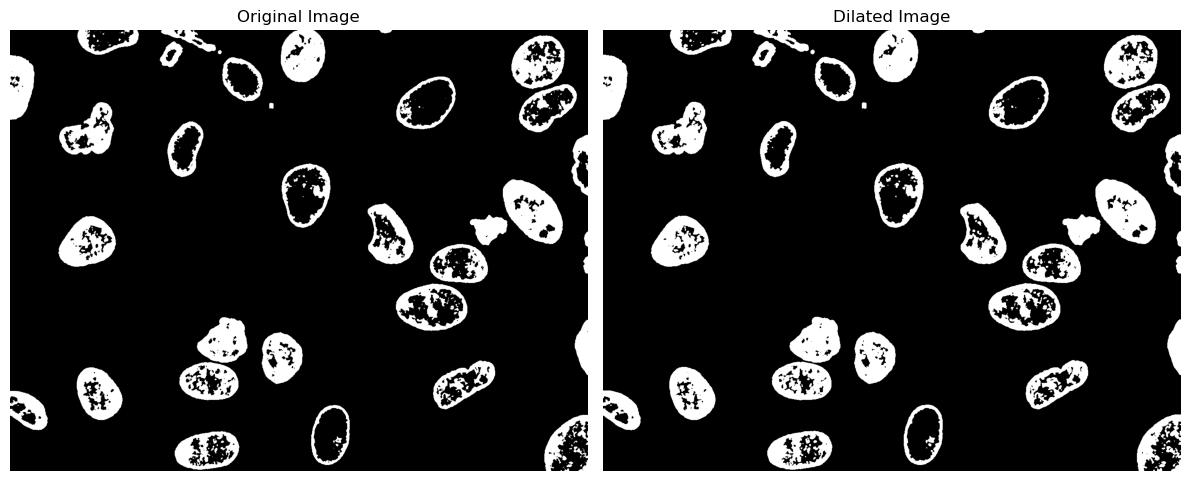

In [ ]:
img = imread('cell_holes.png') 
footprint = morph.square(2) # TODO: test out different sizes of the square to fill out the holes of original image 
dilation = morph.binary_dilation(img, footprint= footprint) # NOTE: this line would be empty for exercise 

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Original cell_holes image 
axes[0].imshow(img, cmap='Greys_r'); axes[0].set_title("Original Image"); axes[0].axis('off')
# Image using Binary Dilation 
axes[1].imshow(dilation, cmap='Greys_r'); axes[1].set_title("Dilated Image"); axes[1].axis('off')
plt.tight_layout()
plt.show()

Contrast this with `binary_fill_holes()` which covers the holes of the image completely without needing to necessarily tune the footprint size, nor requires multiple iterations of `binary_dilation` of the image to achieve hole filling 

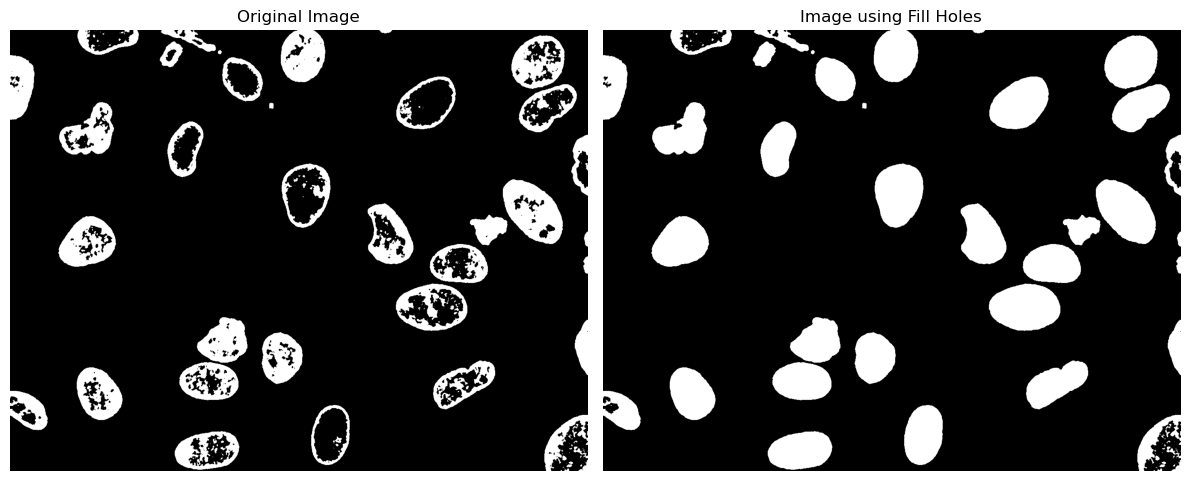

In [ ]:
# TODO: try writing out function calling upon method for fill holes algorithm 
filled = binary_fill_holes(img, ) # NOTE: line would be empty 

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Original cell_holes image 
axes[0].imshow(img, cmap='Greys_r'); axes[0].set_title("Original Image"); axes[0].axis('off')

# Image using Fill Holes Algorithm 
axes[1].imshow(filled, cmap='Greys_r'); axes[1].set_title("Image using Fill Holes"); axes[1].axis('off')
plt.tight_layout()
plt.show()

### Further Notes: Hole Filling for Greyscale Images

Fill Holes algorithm can also work for greyscale images as well. Similar in principle, one can consider "holes" to be darker (lower value) pixel intensity regions surrounded by brighter (higher value) pixel regions. 

The goal of greyscale hole filling is to raise up the hole region's intensity to match it with that of the boundary intensity. **This can be expanded more on 9.6 Morphological Reconstruction and beyond the scope of this presentation.**  

It must be noted that there is no definitive "fill holes" method for a greyscale image, but using morphological reconstruction, one can fill the holes of a grey scale image 


